# Özet

Aşağıdaki kod akışında bir kasırga hasar tespiti görüntü sınıflandırma projesinin uçtan uca kodlarını topluca özetledin: Önce **veri keşfi** için klasör/dosya boyutlarını yazdırdın; ardından tüm .jpg/.jpeg dosyalarını toplayıp path, damage/no_damage etiketi, train/validation/test bölünmesi ve dosya adından türetilen enlem–boylam bilgileriyle bir DataFrame oluşturdun. Bu koordinatlarla hem split **(train/validation)** hem de etiket **(damage/no_damage)** dağılımlarını saçılım grafikleriyle görselleştirdin; ayrıca seçili örnekleri ızgara (grid) halinde gösterip RGB histogramları ile renk kanal dağılımlarını inceledin. Ön işleme tarafında, luma kanalına **HE/AHE/CLAHE** uygulayan yardımcılar, **RMS kontrast** ve **Shannon entropi metrikleriyle** birlikte denendi ve orijinal–işlenmiş görseller yan yana çizildi. Eğitim veri hattında ImageDataGenerator ile CLAHE tabanlı he_preprocess ve **dönüş/ kaydırma/ yakınlaştırma/ ayna/ parlaklık gibi augmentation**’lar (validation/test’e yalnızca ön işleme) kuruldu. Model olarak **ImageNet ağırlıklı EfficientNetB4****** omurgası kullanıldı; katmanların bir kısmı dondurulup son kısmı fine-tune edildi; üzerine **GAP, BN, Dropout ve L2’li Dense(256, ReLU) + sigmoid çıkış** eklendi. Optimizasyon için **Adam/AdamW/SGD** seçenekli, **binary_crossentropy** kayıplı ve **accuracy/AUC/precision/recall metrikli** derleme yapıldı. Hiperparametre aramasında bir uzay tanımlayıp **random search** ile birkaç deneme koştun; **TensorBoard, ModelCheckpoint** (val AUC ile en iyi modeli best.keras kaydetme), **EarlyStopping ve ReduceLROnPlateau** callback’leriyle eğitimi izledin; her denemenin sonuçlarını /kaggle/working/random_search_results.json dosyasına yazıp en iyi konfigürasyonu seçtin. Seçilen ayarlarla 10 epoch ek eğitim yaptın, **TensorBoard’ı** notebook içinde açtın ve test/validation metriklerini raporladın. Açıklanabilirlik için son konvolüsyon katmanını otomatik bulan yardımcıyla **Grad-CAM** ısı haritaları üretip orijinal görüntülerin üzerine bindirerek /kaggle/working/gradcam* klasörlerine kaydettin. Son olarak test seti üzerinde classification report ve hem ham hem de satır-normalize confusion matrix çizimleriyle hataların sınıf bazında profili çıkarılmıştır.

Bu hücre, görüntü sınıflandırma projesi için çalışma ortamını hazırlar: dosya ve yol işlemleri için os ve Path, sayısal/veri çerçevesi işlemleri için numpy ve pandas, görselleştirme için matplotlib ve seaborn, görüntü işleme ve zenginleştirme için cv2 ile skimage (örn. kontrast/entropi), veri artırma ve akış tabanlı yükleme için ImageDataGenerator, derin öğrenme mimarisi ve eğitim süreci için TensorFlow/Keras (katmanlar, düzenlileştirme, geri çağırmalar: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard), önceden eğitilmiş EfficientNetB4 ve model tanımlama araçlarını içeri aktarır; en sonda kurulu TensorFlow sürümünü yazdırarak ortamın doğrulanmasını sağlar.

# Kütüphaneler

In [6]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random, math, json, shutil, datetime
from skimage import exposure, img_as_ubyte
from skimage.measure import shannon_entropy
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
print('TensorFlow:', tf.__version__)

TensorFlow: 2.18.0


# Keşifsel Veri Analizi

Bu kod, verilen ana klasör altındaki train_another, validation_another, test_another ve test klasörlerinde bulunan dosya ve alt klasörlerin boyutlarını MB cinsinden hesaplayarak ekrana yazdırmaktadır. Fonksiyon, her bir öğeyi kontrol ederek dosya ise doğrudan boyutunu, klasör ise içindeki tüm dosyaların toplam boyutunu ve dosya sayısını göstermektedir. Böylece veri setindeki dosyaların dağılımı ve kapladıkları alan kolayca görülebilmektedir.

In [8]:
input_path = '/kaggle/input/satellite-images-of-hurricane-damage/'

def print_file_sizes(input_path, subset):
    print('{}:'.format(subset))
    print('')
    path = input_path + subset + '/'
    for f in os.listdir(path):
        if not os.path.isdir(path + f):
            print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
        else:
            sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
            print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
    print('')
    
print_file_sizes(input_path, 'train_another')
print_file_sizes(input_path, 'validation_another')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'test')

train_another:

damage                        12.56MB (5000 files)
no_damage                     15.07MB (5000 files)

validation_another:

damage                        2.52MB (1000 files)
no_damage                     3.02MB (1000 files)

test_another:

damage                        20.12MB (8000 files)
no_damage                     3.01MB (1000 files)

test:

damage                        2.53MB (1000 files)
no_damage                     2.99MB (1000 files)



Bu kod, klasör yapısındaki tüm .jpg ve .jpeg dosyalarını bulup bir DataFrame’e aktarmakta ve her görsel için ek bilgiler çıkarmaktadır. Dosya yolundan görselin hangi sınıfa ait olduğu (damage), hangi veri grubunda bulunduğu (data_split), dosya adından konum bilgisi (location) ve bu konumdan enlem-boylam değerleri (lat, lon) ayrıştırılmaktadır. Son olarak, dosya yolu string formatına çevrilerek tablo daha okunabilir hale getirilmektedir.

In [10]:
image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string
image_df.head()

path  damage     data_split  \
0  /kaggle/input/satellite-images-of-hurricane-da...  damage  train_another   
1  /kaggle/input/satellite-images-of-hurricane-da...  damage  train_another   
2  /kaggle/input/satellite-images-of-hurricane-da...  damage  train_another   
3  /kaggle/input/satellite-images-of-hurricane-da...  damage  train_another   
4  /kaggle/input/satellite-images-of-hurricane-da...  damage  train_another   

                        location        lon        lat  
0           -95.656807_29.835212 -95.656807  29.835212  
1  -95.630673_29.775671999999997 -95.630673  29.775672  
2           -95.639432_29.844975 -95.639432  29.844975  
3  -95.586533_29.757163000000002 -95.586533  29.757163  
4            -95.270494_29.60561 -95.270494  29.605610

Bu kod, görsellerin konum bilgilerini kullanarak iki ayrı dağılım grafiği oluşturmaktadır. İlk grafikte (ax[0]), eğitim (train_another) ve doğrulama (validation_another) veri setlerindeki görsellerin enlem-boylam dağılımı gösterilmekte, böylece veri setinin coğrafi olarak nasıl bölündüğü görselleştirilmektedir. İkinci grafikte (ax[1]) ise hasarlı (damage) ve hasarsız (no_damage) sınıflara ait görsellerin konum dağılımları karşılaştırılmaktadır. Noktalar küçük boyutta (s=3) ve yarı saydam (alpha=0.25) çizilerek yoğunlukların daha net gözlemlenmesi sağlanmıştır. Bu sayede hem veri bölünmelerinin hem de etiketlerin coğrafi dağılımı kolayca analiz edilebilmektedir.

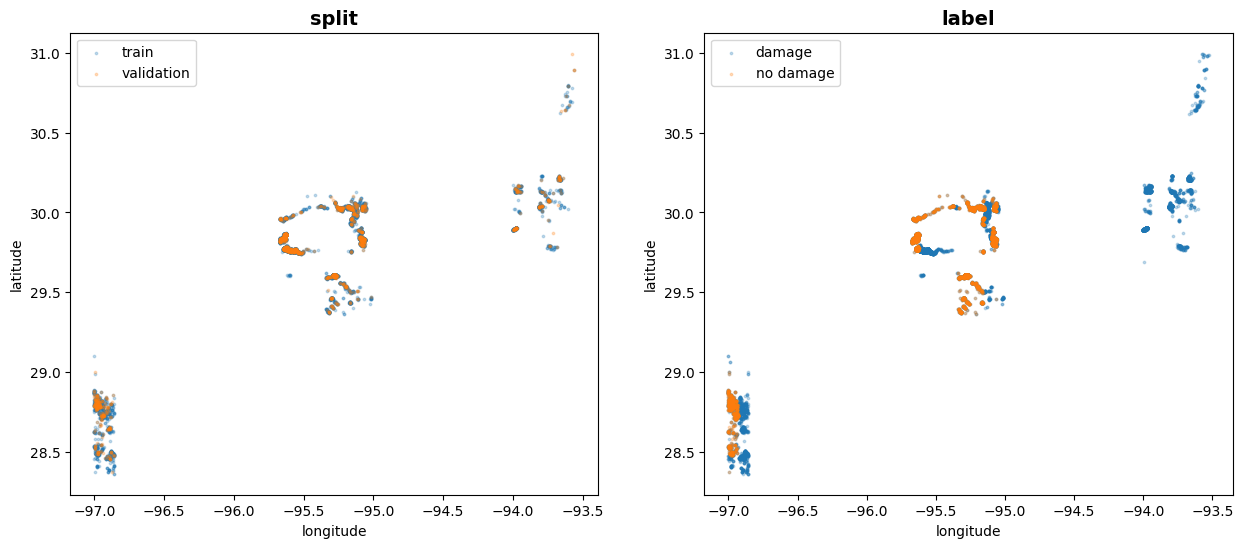

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 3
alpha = 0.25

image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

Bu kod, görsellerin konum dağılımlarını üç farklı bakış açısıyla yan yana karşılaştırmalı olarak göstermektedir. İlk grafik (`ax[0]`), yalnızca hasarlı (`damage`) görsellerin enlem-boylam dağılımını mavi renkle görselleştirir. İkinci grafik (`ax[1]`), hem hasarlı hem de hasarsız görselleri siyah noktalarla birlikte göstererek tüm veri setinin coğrafi yoğunluğunu ortaya koyar. Üçüncü grafik (`ax[2]`) ise yalnızca hasarsız (`no_damage`) görsellerin dağılımını turuncu renkle sunar. Grafiklerde eksenler ortak paylaşıldığı için (sharex, sharey), görsellerin farklı etiketlere göre aynı coğrafi bölgede nasıl dağıldığı rahatlıkla karşılaştırılabilir. Ayrıca eksenler Houston bölgesini kapsayacak şekilde (-95.3, -95) boylam ve (29.7, 30.2) enlem aralığıyla sınırlandırılmıştır.

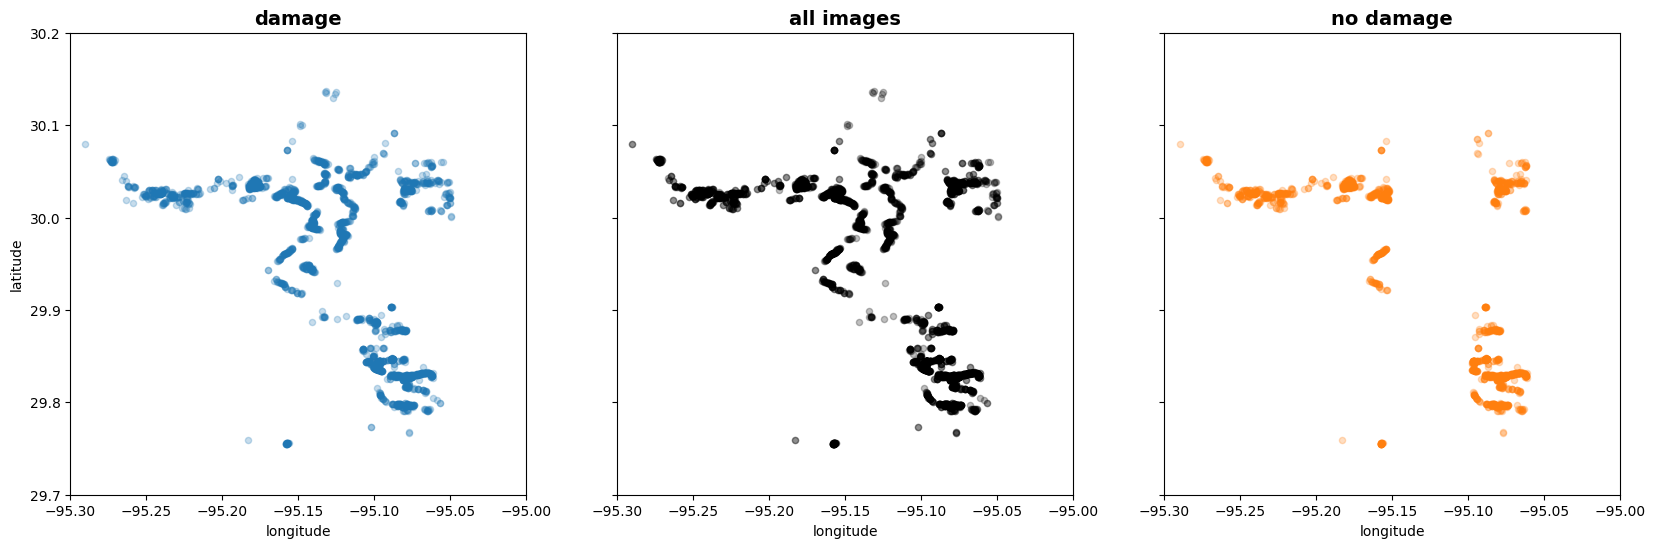

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)
s = 20
alpha = 0.25
ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=14, fontweight='bold')
ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=14, fontweight='bold')
ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=14, fontweight='bold')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[2].set_xlabel('longitude')
ax[0].set_xlim(-95.3,-95)
ax[0].set_ylim(29.7,30.2)
plt.show(fig)

Bu kod, veri setindeki örnek görüntülerden 20’si hasarlı (damage) ve 20’si hasarsız (no damage) olacak şekilde toplamda 40 tanesini grid düzeninde görselleştirmektedir.
Öncelikle 4 satır ve 10 sütundan oluşan alt grafikler (subplots) hazırlanır. İlk döngüde image_df_dmg içerisindeki ilk 20 hasarlı görsel okunarak imshow ile ekrana getirilir ve başlıkları damage olarak ayarlanır. İkinci döngüde ise image_df_nodmg içerisindeki ilk 20 hasarsız görsel aynı şekilde gösterilir ve başlıkları no damage olarak eklenir.
Sonuç olarak, tek bir figür üzerinde 40 örnek görsel yan yana gösterilerek veri setindeki sınıflar hakkında görsel bir fikir edinmek mümkün olur.

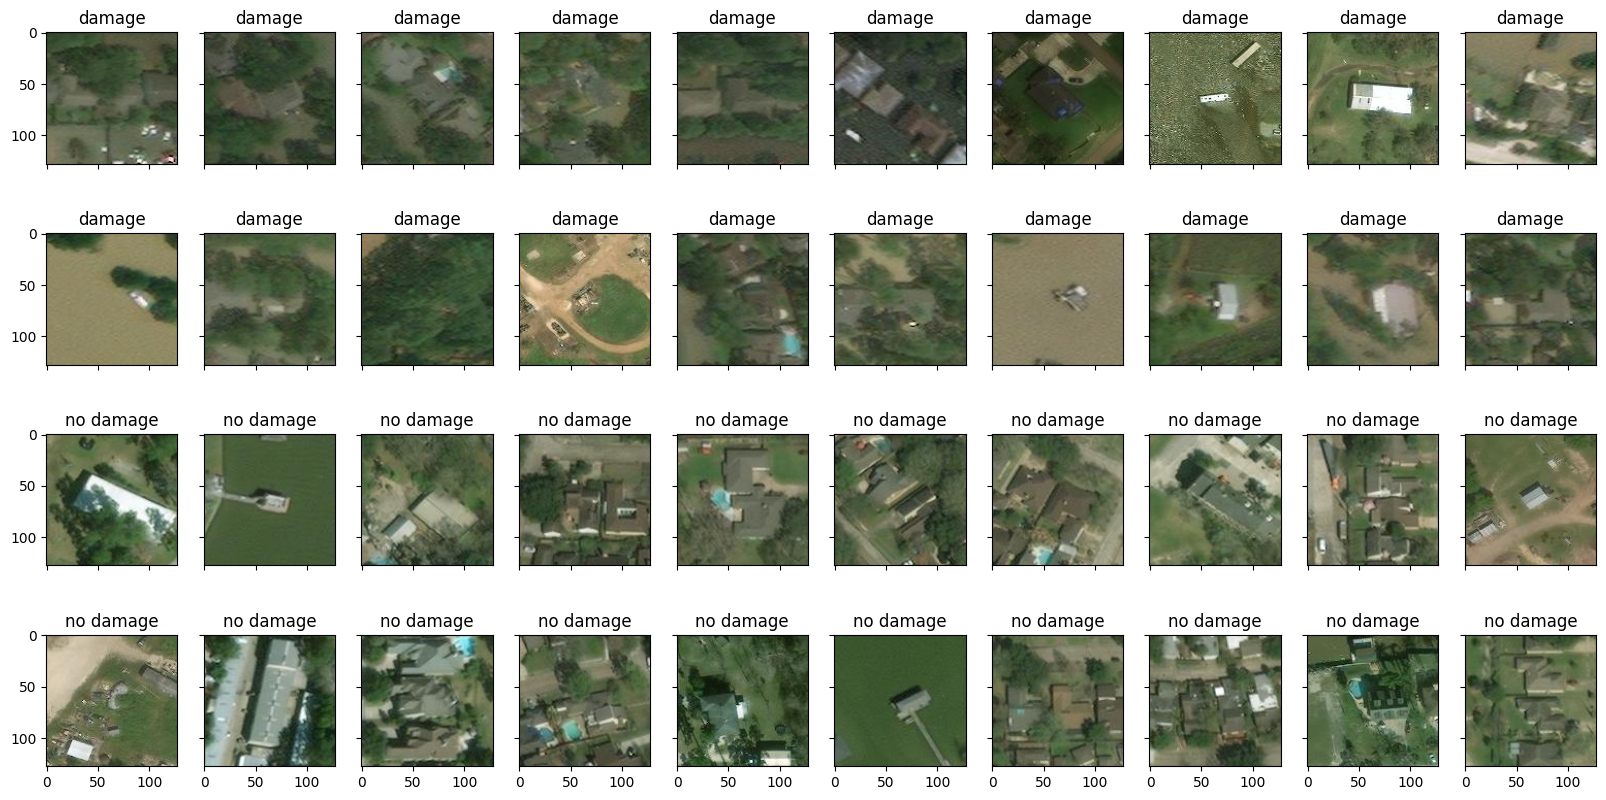

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))
ax = ax.flatten()

for i in range(20):
    img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')
    
for i in range(20,40):
    img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')
    
plt.show()

Bu kod, veri setinden belirli aralıklarla seçilmiş hasarlı (damage) ve hasarsız (no damage) örnek görselleri görselleştirmektedir.
Öncelikle 4 satır ve 3 sütundan oluşan bir grafik düzeni oluşturulur. selected_dmg dizisi her 100. görseli, selected_nodmg dizisi ise her 99. görseli seçerek çeşitlilik sağlamak için kullanılır. İlk 6 alt grafikte seçilen hasarlı görüntüler, sonraki 6 alt grafikte ise seçilen hasarsız görüntüler gösterilir.
Sonuçta toplam 12 görsel (6 damage + 6 no damage) tek bir figür üzerinde yan yana ve kolay karşılaştırma yapılabilecek şekilde sunulmuş olur.

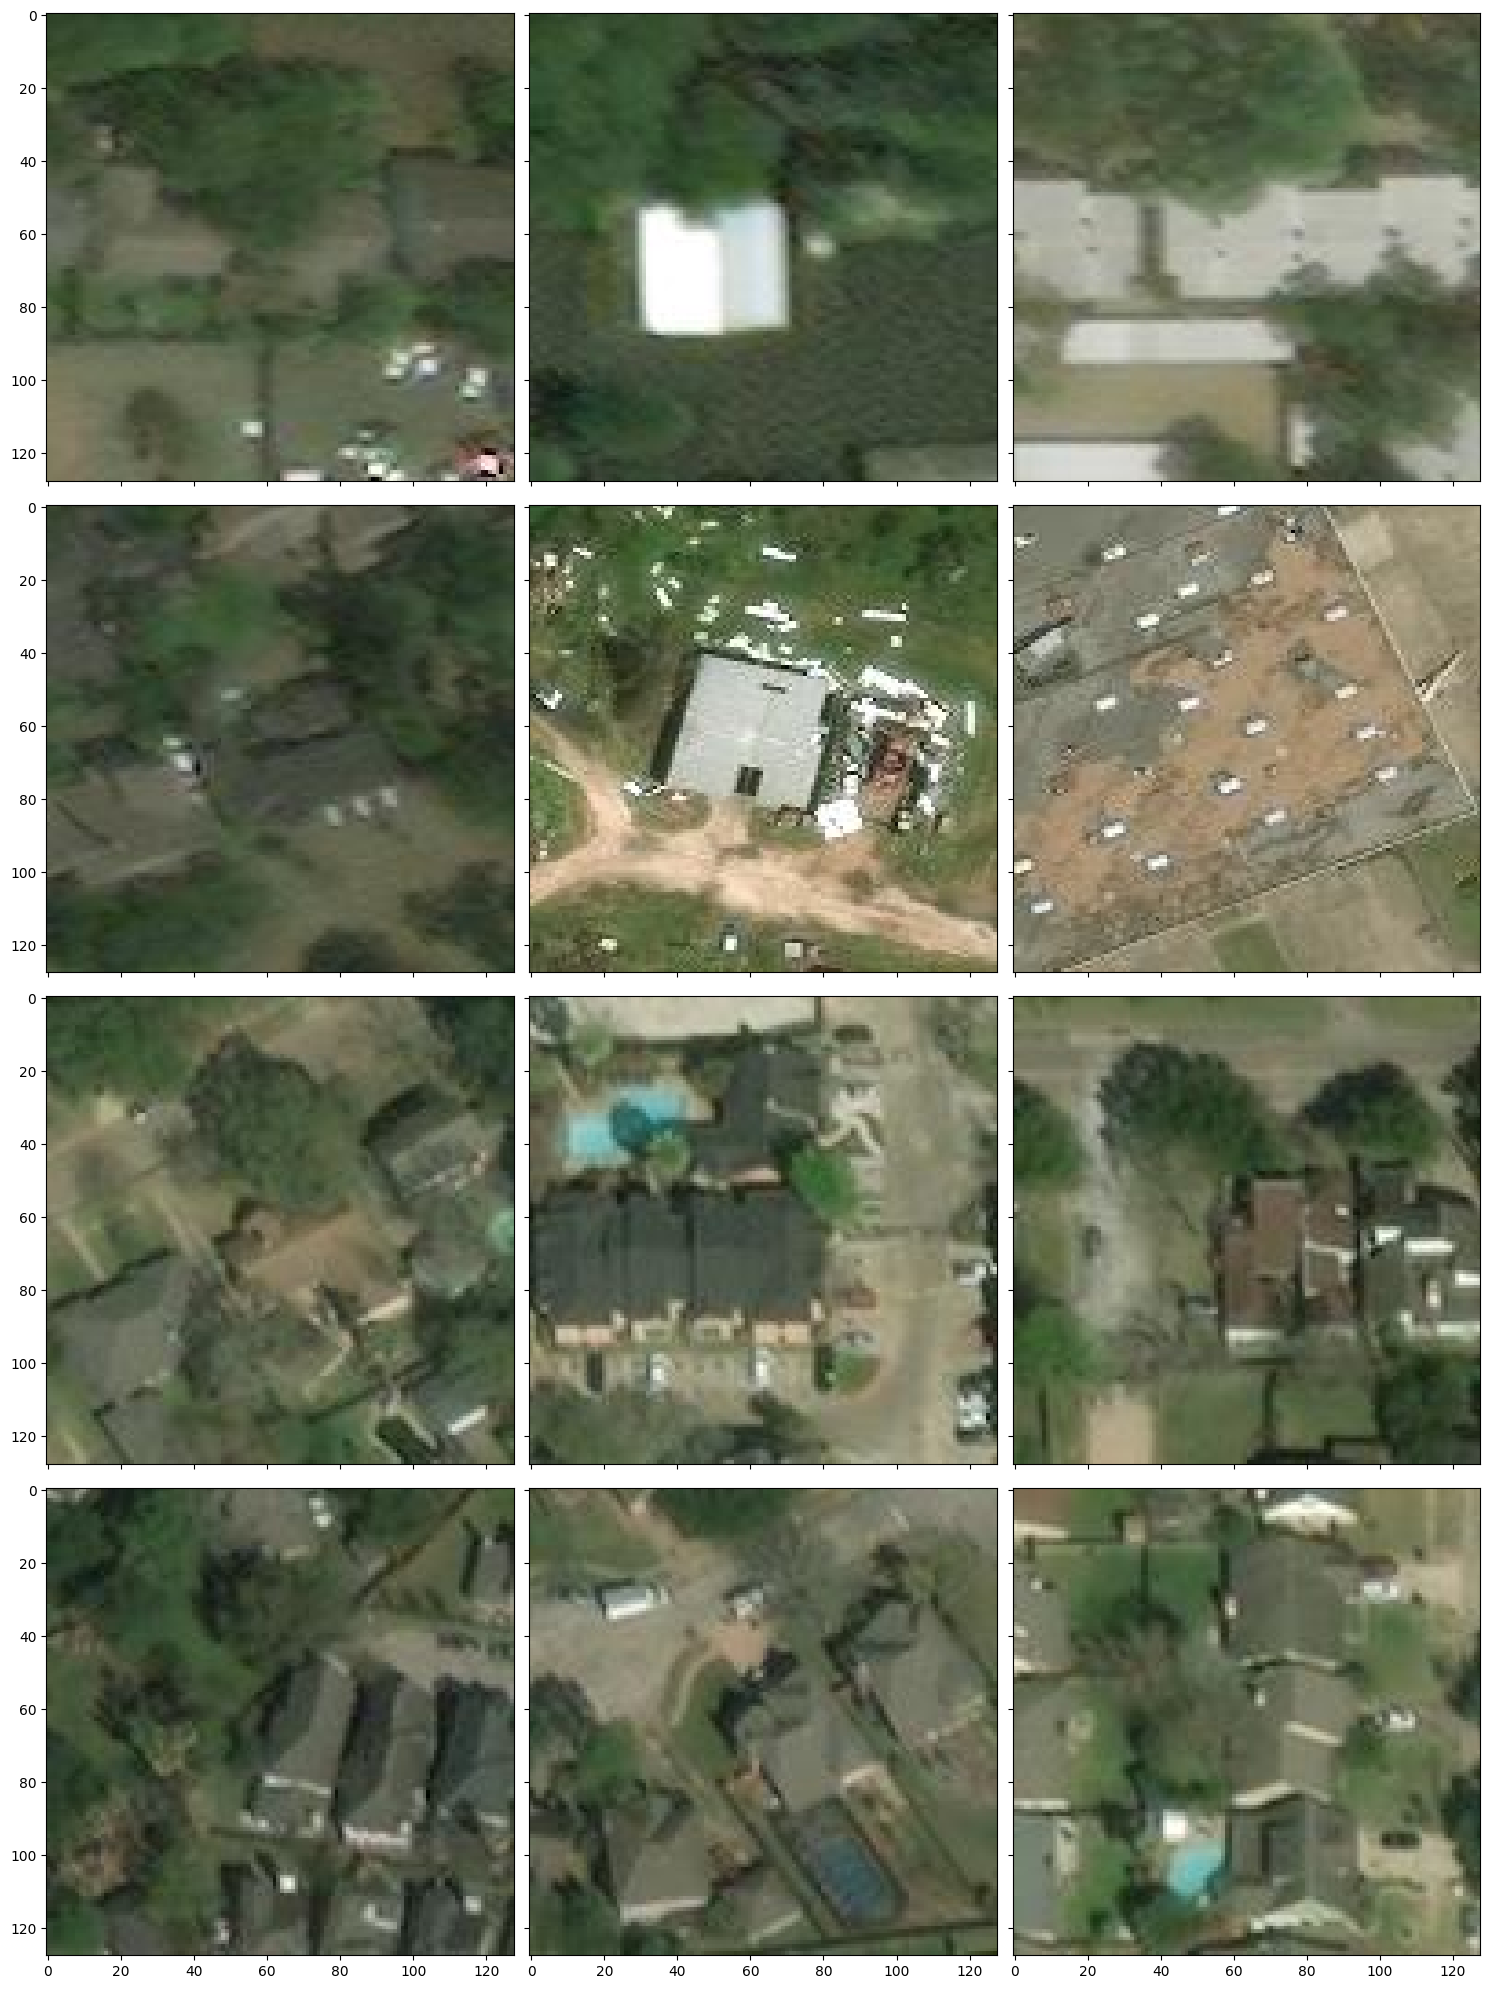

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(15,20))
ax = ax.flatten()
selected_dmg = np.array([0,1,2,3,4,5])*100
selected_nodmg = np.array([0,1,2,3,4,5])*99
for i in range(6):
    img = cv2.imread(image_df_dmg['path'][selected_dmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    
for i in range(6):
    img = cv2.imread(image_df_nodmg['path'][selected_nodmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i+6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig.tight_layout()
plt.show()

Bu kod, seçilen bir görüntünün RGB kanal dağılımlarını histogram şeklinde göstermektedir.
jpg_channels listesinde her kanalın adı, jpg_channel_colors listesinde ise grafikte kullanılacak renkler tanımlanmıştır.
Döngü içinde görüntünün her kanalındaki piksel değerleri (0-255) düzleştirilip (flatten) histogram olarak çizilir.
Böylece mavi, yeşil ve kırmızı kanalların piksel yoğunluk dağılımları aynı grafik üzerinde yarı saydam (alpha=0.5) olarak gösterilir.
set_xlim(0,255) ile eksen, piksel aralığını tam kapsayacak şekilde ayarlanır.
Sonuçta, görseldeki renk yoğunluklarının her kanal bazında nasıl dağıldığı net bir şekilde analiz edilebilir.

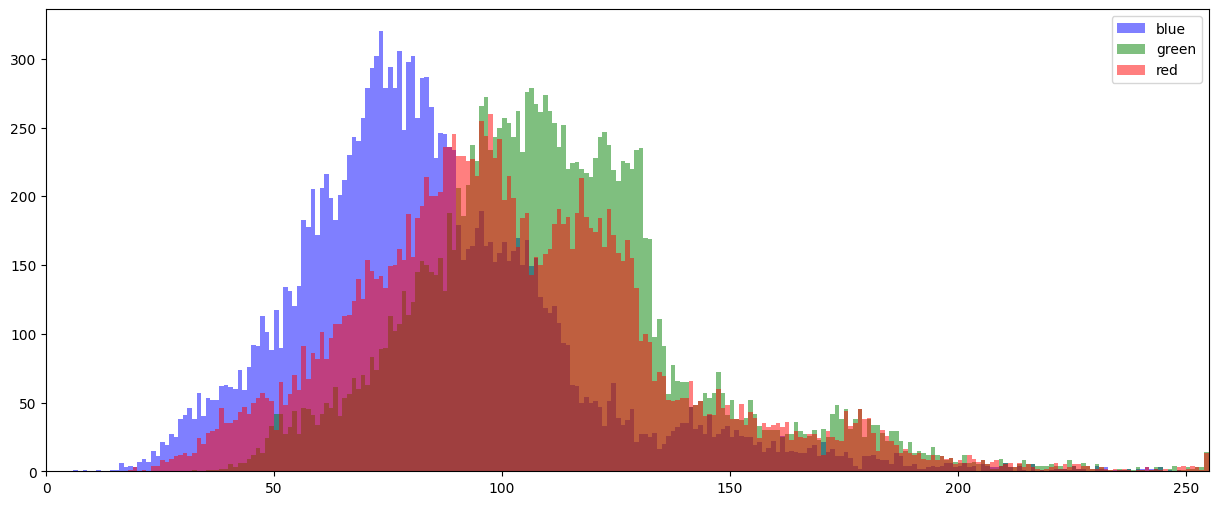

In [20]:
jpg_channels = ['blue','green','red']
jpg_channel_colors = ['b','g','r']

fig, ax = plt.subplots(figsize=(15,6))
for i in range(len(jpg_channels)):
    ax.hist(img[:,:,i].flatten(), bins=np.arange(256),
            label=jpg_channels[i], color=jpg_channel_colors[i], alpha=0.5)
    ax.legend()
ax.set_xlim(0,255)
plt.show(fig)

Bu kod, train_another altındaki sınıflardan her biri için rastgele seçilen birkaç görüntüyü okuyup yeniden boyutlandırdıktan sonra, luma (Y) kanalında üç farklı kontrast iyileştirme tekniğini uygular: klasik histogram eşitleme (HE), uyarlamalı histogram eşitleme (AHE) ve karo tabanlı CLAHE. Yardımcı fonksiyonlar renk/format dönüşümleri (BGR↔YCrCb, gri), güvenli uint8 dönüşümü ve RMS kontrast ile Shannon entropisi hesaplamasını yapar. Her görüntü için özgün hâl ve işlenmiş sürümlerinin metrikleri (RMS kontrast, entropi) terminale yazdırılır; ardından 1×4 panelde (Original, HE, AHE, CLAHE) görsel karşılaştırma çizilir. Sonuç olarak, farklı iyileştirme yöntemlerinin yerel kontrast ve bilgi içeriğine (entropi) etkisi hızlıca sayısal ve görsel olarak analiz edilir.


[damage] -93.949315_29.996042.jpeg
ORIGINAL | RMS Contrast: 0.1026 | Entropy: 6.142
HE       | RMS Contrast: 0.2875 | Entropy: 6.017
AHE      | RMS Contrast: 0.1742 | Entropy: 7.200
CLAHE    | RMS Contrast: 0.1516 | Entropy: 7.149


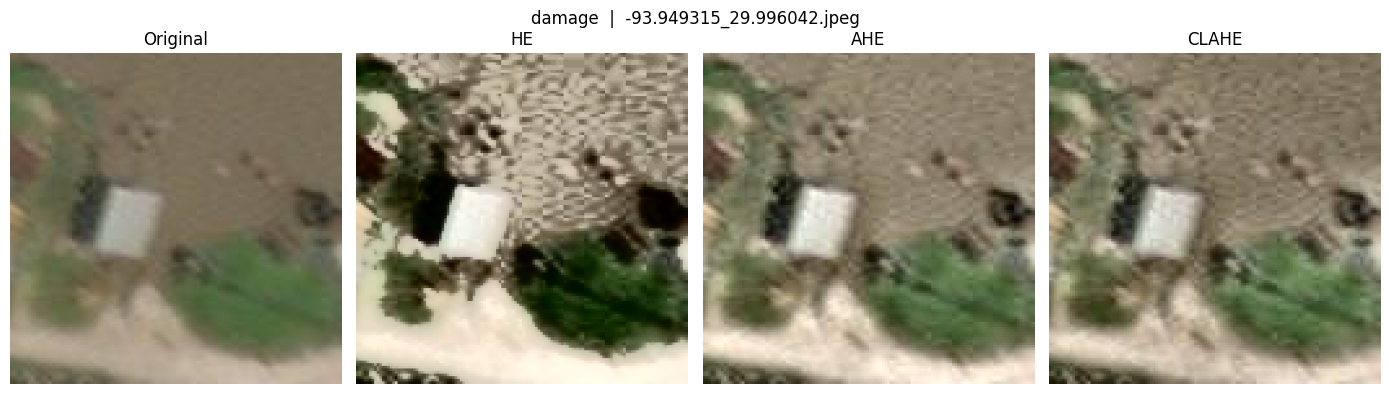


[damage] -95.62306_29.777248999999998.jpeg
ORIGINAL | RMS Contrast: 0.1270 | Entropy: 6.313
HE       | RMS Contrast: 0.2903 | Entropy: 6.270
AHE      | RMS Contrast: 0.1947 | Entropy: 7.271
CLAHE    | RMS Contrast: 0.1689 | Entropy: 7.281


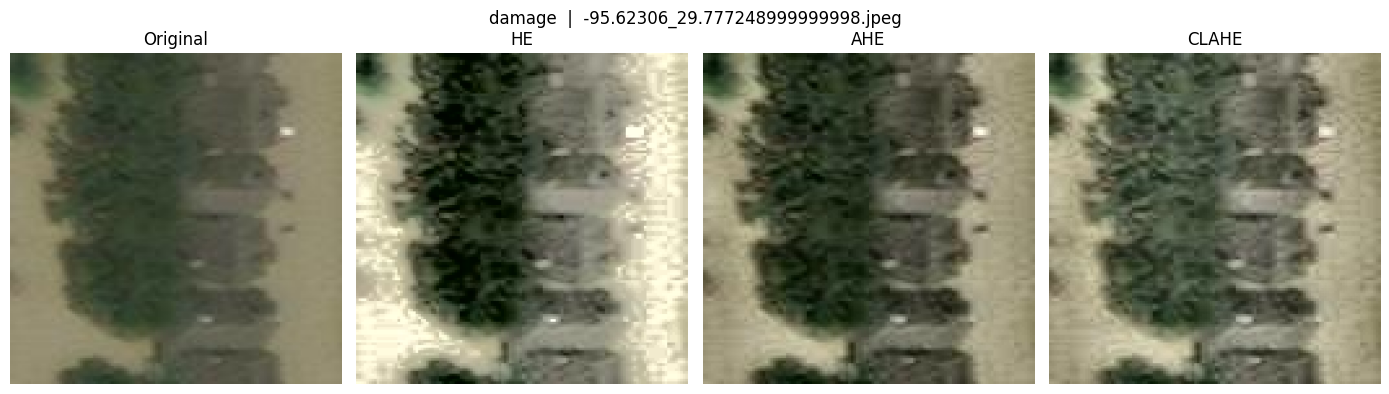


[no_damage] -95.630881_29.853215000000002.jpeg
ORIGINAL | RMS Contrast: 0.1186 | Entropy: 6.849
HE       | RMS Contrast: 0.2881 | Entropy: 6.756
AHE      | RMS Contrast: 0.1962 | Entropy: 7.642
CLAHE    | RMS Contrast: 0.1787 | Entropy: 7.522


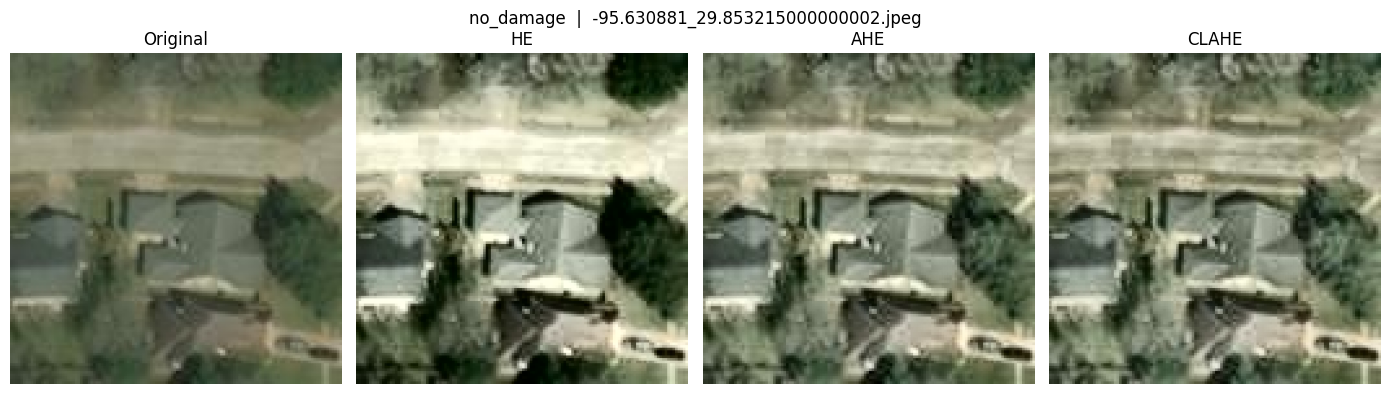


[no_damage] -95.653862_29.836562.jpeg
ORIGINAL | RMS Contrast: 0.1168 | Entropy: 6.861
HE       | RMS Contrast: 0.2878 | Entropy: 6.735
AHE      | RMS Contrast: 0.1976 | Entropy: 7.633
CLAHE    | RMS Contrast: 0.1843 | Entropy: 7.556


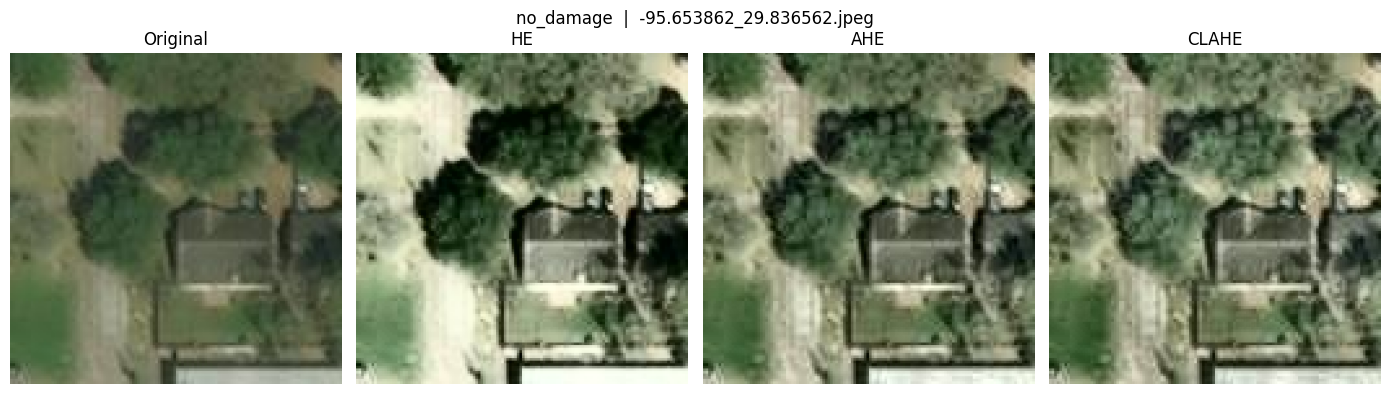


RMS yüksekliği genelde daha iyi lokal kontrasta işaret eder; entropi aşırı yükseliyorsa gürültü/artefakt artmış olabilir.


In [22]:
base_dir = "/kaggle/input/satellite-images-of-hurricane-damage"
subset  = "train_another"   
n_per_class = 2             
target_size = (256, 256)    

ahe_clip_limit = 0.01       
clahe_clip_limit = 3.0     
clahe_tile_grid = (8, 8)

def to_rgb(img):
    if img is None:
        return None
    if len(img.shape) == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:
        return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img

def resize_keep(img, size):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def rms_contrast(gray):
    g = gray.astype(np.float32) / 255.0
    return float(g.std())

def ensure_uint8(imgf):
    if imgf.dtype == np.float32 or imgf.dtype == np.float64:
        if imgf.max() <= 1.0:
            return img_as_ubyte(imgf)  # skimage güvenli dönüşüm
        else:
            return np.clip(imgf, 0, 255).astype(np.uint8)
    if imgf.dtype != np.uint8:
        return np.clip(imgf, 0, 255).astype(np.uint8)
    return imgf

def hist_equalization_rgb_luma(bgr):
    ycbcr = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)
    y_eq = cv2.equalizeHist(y)
    out = cv2.merge([y_eq, cb, cr])
    return cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

def adaptive_he_rgb_luma(bgr, clip_limit=0.01):
    ycbcr = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)
    y_norm = y.astype(np.float32) / 255.0
    y_ahe = exposure.equalize_adapthist(y_norm, clip_limit=clip_limit)
    y_ahe_u8 = ensure_uint8(y_ahe)
    out = cv2.merge([y_ahe_u8, cb, cr])
    return cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

def clahe_rgb_luma(bgr, clip_limit=3.0, tile_grid=(8,8)):
    ycbcr = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    y_eq = clahe.apply(y)
    out = cv2.merge([y_eq, cb, cr])
    return cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

def metrics_report(bgr, name):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    rms = rms_contrast(gray)
    ent = shannon_entropy(gray)  # bit cinsinden bilgi içeriği
    return f"{name:<8} | RMS Contrast: {rms:.4f} | Entropy: {ent:.3f}"

data_dir = os.path.join(base_dir, subset)
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Dizin bulunamadı: {data_dir}\nLütfen 'base_dir' ve 'subset' değişkenlerini kontrol edin.")

classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()

samples = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
    if not imgs:
        continue
    chosen = random.sample(imgs, min(n_per_class, len(imgs)))
    for fname in chosen:
        samples.append((cls, os.path.join(cls_dir, fname)))

if not samples:
    raise RuntimeError("Seçilen alt dizinde görüntü bulunamadı.")

for cls, path in samples:
    bgr = cv2.imread(path)
    if bgr is None:
        print(f"Okuma hatası: {path}")
        continue
    bgr = to_rgb(bgr)             # BGR
    bgr = resize_keep(bgr, target_size)

    he    = hist_equalization_rgb_luma(bgr)
    ahe   = adaptive_he_rgb_luma(bgr, clip_limit=ahe_clip_limit)
    clahe = clahe_rgb_luma(bgr, clip_limit=clahe_clip_limit, tile_grid=clahe_tile_grid)

    print(f"\n[{cls}] {os.path.basename(path)}")
    print(metrics_report(bgr,   "ORIGINAL"))
    print(metrics_report(he,    "HE"))
    print(metrics_report(ahe,   "AHE"))
    print(metrics_report(clahe, "CLAHE"))

    plt.figure(figsize=(14, 4))
    plt.suptitle(f"{cls}  |  {os.path.basename(path)}")
    plt.subplot(1,4,1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(cv2.cvtColor(he, cv2.COLOR_BGR2RGB)); plt.title("HE"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(cv2.cvtColor(ahe, cv2.COLOR_BGR2RGB)); plt.title("AHE"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB)); plt.title("CLAHE"); plt.axis("off")
    plt.tight_layout(); plt.show()

print("\nRMS yüksekliği genelde daha iyi lokal kontrasta işaret eder; entropi aşırı yükseliyorsa gürültü/artefakt artmış olabilir.")


Bu kod, eğitim verisindeki her sınıftan rastgele seçilen birkaç görseli alıp histogram eşitleme (HE) yöntemiyle kontrast geliştirme uygulamasını göstermektedir.
Öncelikle apply_hist_eq fonksiyonu, görüntüyü YCrCb renk uzayına çevirerek sadece luma (Y) kanalına histogram eşitleme uygular; ardından yeniden birleştirerek BGR formatına döndürür. Döngü içerisinde her sınıftan n_per_class kadar örnek seçilir, boyutları (224×224) olacak şekilde yeniden ölçeklendirilir ve hem orijinal hem de HE uygulanmış hali yan yana görselleştirilir.
Sonuç olarak, histogram eşitlemenin görsel kontrast üzerindeki etkisi açıkça karşılaştırmalı biçimde gözlemlenebilmektedir.

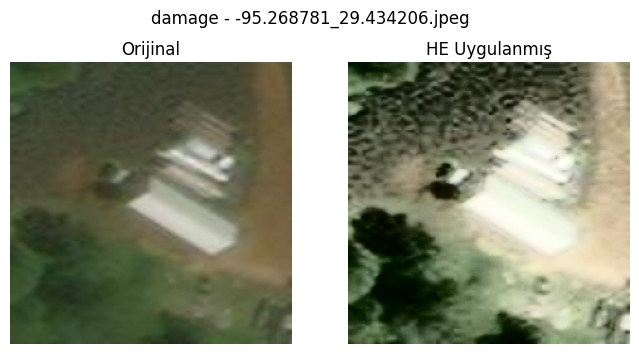

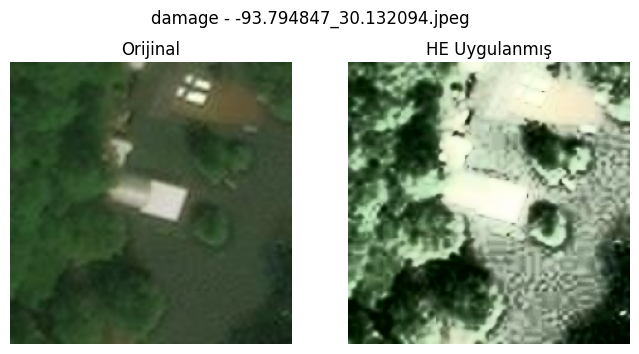

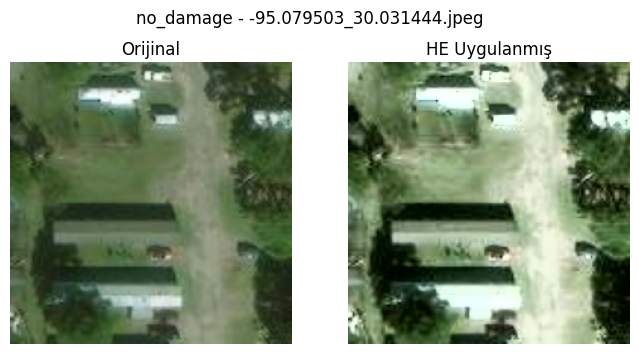

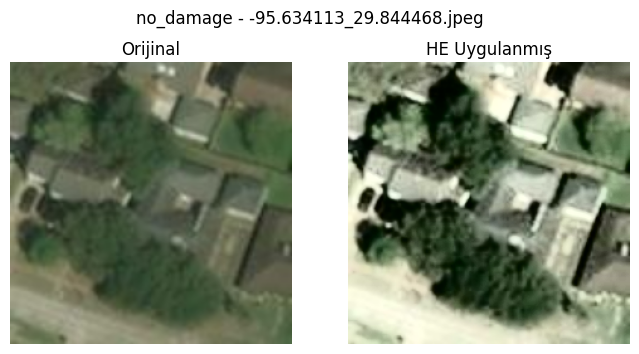

In [24]:
base_dir = "/kaggle/input/satellite-images-of-hurricane-damage/train_another"
n_per_class = 2 
target_size = (224, 224)

def apply_hist_eq(img_bgr):
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    merged = cv2.merge([y_eq, cr, cb])
    return cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)

classes = sorted(os.listdir(base_dir))

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    chosen = random.sample(imgs, min(n_per_class, len(imgs)))

    for fname in chosen:
        path = os.path.join(cls_path, fname)
        img = cv2.imread(path)
        if img is None:
            continue

        img = cv2.resize(img, target_size)
        he_img = apply_hist_eq(img)

        plt.figure(figsize=(8,4))
        plt.suptitle(f"{cls} - {fname}", fontsize=12)
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Orijinal")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(he_img, cv2.COLOR_BGR2RGB))
        plt.title("HE Uygulanmış")
        plt.axis("off")
        plt.show()


# Veri Önişleme

Bu fonksiyon, giriş görüntüsünü ön işleme tabi tutarak modele daha uygun hale getirir. Öncelikle görüntüyü uygun veri tipine çevirir ve RGB formatından YCrCb renk uzayına dönüştürür. Ardından parlaklık bileşeni olan Y kanalına CLAHE (Contrast Limited Adaptive Histogram Equalization) uygulanarak kontrast artırılır. İşlenmiş Y kanalı yeniden Cr ve Cb ile birleştirilip RGB formatına döndürülür. Son adımda piksel değerleri 0–1 aralığına normalize edilerek modelin girişine hazır hale getirilir.

In [29]:
def he_preprocess(img):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_eq = clahe.apply(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    img_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    img_eq = img_eq.astype("float32") / 255.0
    return img_eq

Bu kod, model eğitiminde kullanılacak veri yükleyicilerini ve artırma (augmentation) işlemlerini tanımlar. Eğitim verileri için `ImageDataGenerator` kullanılarak **ön işleme fonksiyonu (`he_preprocess`)** uygulanmakta, ayrıca dönme, kaydırma, yakınlaştırma, yatay/dikey çevirme ve parlaklık değişiklikleri gibi veri artırma yöntemleriyle modelin daha genelleştirilebilir hale gelmesi sağlanmaktadır. Doğrulama ve test verileri için ise yalnızca `he_preprocess` fonksiyonu uygulanır, böylece bu veriler üzerinde ek oynama yapılmaz. Sonrasında `flow_from_directory` metodu ile ilgili klasörlerden (`train_another`, `validation_another`, `test`) görseller belirtilen boyutlara (`380x380`) ölçeklendirilip uygun batch boyutu ve etiketleme şekliyle (`binary`) modele beslenmeye hazır hale getirilir.

In [30]:
TARGET_SIZE = (380, 380) 
BATCH_SIZE  = 32
SEED        = 42

train_aug = ImageDataGenerator(
    preprocessing_function=he_preprocess,
    rotation_range=30,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)
val_test_aug = ImageDataGenerator(preprocessing_function=he_preprocess)

train_dir = "/kaggle/input/satellite-images-of-hurricane-damage/train_another"
val_dir   = "/kaggle/input/satellite-images-of-hurricane-damage/validation_another"
test_dir  = "/kaggle/input/satellite-images-of-hurricane-damage/test"

train_generator = train_aug.flow_from_directory(
    train_dir, target_size=TARGET_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True, seed=SEED
)
val_generator = val_test_aug.flow_from_directory(
    val_dir, target_size=TARGET_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)
test_generator = val_test_aug.flow_from_directory(
    test_dir, target_size=TARGET_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Model

Bu fonksiyon, **EfficientNetB4** tabanlı ikili sınıflandırma modeli oluşturur ve optimize eder. Öncelikle ImageNet ağırlıklarıyla yüklenen EfficientNetB4 gövdesinin katmanları dondurulur; yalnızca son kısmın belirli bir oranı (`trainable_ratio`) yeniden eğitime açılır. Çıkış katmanına ek olarak global ortalama havuzlama, batch normalization, dropout ve L2 düzenlileştirme ile donatılmış bir tam bağlantılı (Dense) katman eklenir. En sonda sigmoid aktivasyonlu bir çıkış katmanı ile ikili sınıflandırma sağlanır. Seçilen optimizere (`adam`, `adamw` veya `sgd`) göre öğrenme oranı ayarlanır ve model, **binary crossentropy** kaybı ve `accuracy`, `AUC`, `precision`, `recall` gibi değerlendirme metrikleriyle derlenir. Böylece model, uyarlanabilir şekilde farklı hiperparametrelerle eğitilmeye hazır hale gelir.

In [31]:
def build_model(lr=1e-4, dropout_rate=0.3, l2_factor=1e-5, trainable_ratio=0.25, optimizer_name="adam"):
    base = EfficientNetB4(include_top=False, weights="imagenet",
                          input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    for i, layer in enumerate(base.layers):
        layer.trainable = False
    n_layers = len(base.layers)
    n_trainable = int(n_layers * trainable_ratio)
    for layer in base.layers[-n_trainable:]:
        layer.trainable = True

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2_factor))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base.input, outputs=outputs)

    if optimizer_name.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == "adamw":
        try:
            opt = keras.optimizers.AdamW(learning_rate=lr, weight_decay=l2_factor)
        except:
            opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == "sgd":
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    else:
        opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc", from_logits=False),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

Bu kod, hiperparametre arama sürecinde kullanılacak parametre uzayını tanımlar ve her seferinde rastgele bir kombinasyon seçmek için yardımcı bir fonksiyon oluşturur.

`HP_SPACE` sözlüğünde öğrenme oranı, dropout oranı, L2 düzenlileştirme katsayısı, eğitilebilir katman oranı, optimizer türü ve epoch sayısı gibi seçenekler listelenmiştir. `sample_hparams()` fonksiyonu, bu seçeneklerden rastgele birer değer seçerek bir hiperparametre seti döndürür. Böylece farklı kombinasyonlar üzerinde **random search** ile model eğitimi gerçekleştirilebilir.


In [32]:
# Eğitim süresi fazla uzayacağı ve kısıtlı GPU olduğundan kaynaklı kısa epoch'lar verildi.
HP_SPACE = {
    "lr":            [5e-5, 1e-4, 2e-4, 5e-4],
    "dropout_rate":  [0.2, 0.3, 0.4, 0.5],
    "l2_factor":     [1e-6, 1e-5, 5e-5, 1e-4],
    "trainable_ratio":[0.15, 0.25, 0.35, 0.50],
    "optimizer_name":["adam", "adamw", "sgd"],
    "epochs":        [4, 6, 8], 
}

def sample_hparams():
    return {
        "lr": random.choice(HP_SPACE["lr"]),
        "dropout_rate": random.choice(HP_SPACE["dropout_rate"]),
        "l2_factor": random.choice(HP_SPACE["l2_factor"]),
        "trainable_ratio": random.choice(HP_SPACE["trainable_ratio"]),
        "optimizer_name": random.choice(HP_SPACE["optimizer_name"]),
        "epochs": random.choice(HP_SPACE["epochs"]),
    }

Bu kod, model eğitimi sırasında kullanılacak **callback fonksiyonlarını** hazırlar.

Öncelikle logların kaydedileceği kök klasör oluşturulur. `make_callbacks` fonksiyonu, her çalışmaya özel bir alt klasör açarak dört önemli callback tanımlar:

* **TensorBoard (`tb`)**: Eğitim sürecinin görsel olarak takip edilebilmesi için logları kaydeder.
* **ModelCheckpoint (`ckpt`)**: Doğrulama AUC metriğini izleyerek en iyi modeli `best.keras` dosyasına kaydeder.
* **EarlyStopping (`es`)**: Doğrulama AUC değeri birkaç epoch boyunca gelişmezse (patience=3) eğitimi erken durdurur ve en iyi ağırlıkları geri yükler.
* **ReduceLROnPlateau (`rlrop`)**: Doğrulama kaybı iyileşmediğinde öğrenme oranını yarıya indirerek daha kararlı bir öğrenme sağlar.

Fonksiyon, callback listesini, en iyi modelin dosya yolunu ve log dizinini döndürür.


In [28]:
ROOT_LOG = "/kaggle/working/logs"
os.makedirs(ROOT_LOG, exist_ok=True)

def make_callbacks(run_name):
    log_dir = os.path.join(ROOT_LOG, run_name)
    tb = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True)
    ckpt_path = os.path.join(log_dir, "best.keras")
    ckpt = ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max",
                           save_best_only=True, verbose=1)
    es = EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    return [tb, ckpt, es, rlrop], ckpt_path, log_dir

Bu kod, rastgele seçilen hiperparametrelerle (**N_TRIALS** kadar) EfficientNetB4 tabanlı modeli eğitip doğrulama setinde AUC değerine göre en iyi denemeyi seçer. Her deneme için TensorBoard/ModelCheckpoint/EarlyStopping/ReduceLROnPlateau callback’leriyle eğitim yürütülür, sonuçlar ve log dizinleri `results` listesine eklenir ve `/kaggle/working/random_search_results.json` dosyasına kaydedilir. En yüksek **val_auc** üreten denemenin ağırlıkları `best.keras`’tan yüklenir (veya o model kullanılır) ve son olarak **test** seti üzerinde metrikler hesaplanıp yazdırılır.

In [ ]:
N_TRIALS = 1 #Eğitim süresi uzun olduğu için 1 değeri verildi.
results = []
best_auc = -1
best_cfg = None
best_path = None
best_model = None

for t in range(N_TRIALS):
    cfg = sample_hparams()
    run_name = f"efnb4_RS_t{t+1}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    callbacks, ckpt_path, log_dir = make_callbacks(run_name)

    print(f"\n[Trial {t+1}/{N_TRIALS}] HParams:", cfg)
    model = build_model(
        lr=cfg["lr"],
        dropout_rate=cfg["dropout_rate"],
        l2_factor=cfg["l2_factor"],
        trainable_ratio=cfg["trainable_ratio"],
        optimizer_name=cfg["optimizer_name"],
    )

    steps_train = len(train_generator)
    steps_val   = len(val_generator)

    history = model.fit(
            train_generator,
            epochs=cfg["epochs"],
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )

val_metrics = model.evaluate(val_generator, verbose=0)
metric_names = model.metrics_names
val_dict = dict(zip(metric_names, val_metrics))
val_auc = float(val_dict.get("auc", 0.0))
print(f"[Trial {t+1}] val_auc={val_auc:.4f} | log_dir={log_dir}")
results.append({"trial": t+1, "hparams": cfg, "val_metrics": val_dict, "log_dir": log_dir})
if val_auc > best_auc:
    best_auc = val_auc
    best_cfg = cfg
    best_path = ckpt_path
    best_model = model 

with open("/kaggle/working/random_search_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nEn iyi deneme AUC:", best_auc)
print("En iyi HP:", best_cfg)
print("Best checkpoint:", best_path)

if best_path and os.path.exists(best_path):
    print("Best weights yükleniyor:", best_path)
    best_final = build_model(**{k:v for k,v in best_cfg.items() if k in ["lr","dropout_rate","l2_factor","trainable_ratio","optimizer_name"]})
    best_final.load_weights(best_path)
else:
    best_final = best_model

test_metrics = best_final.evaluate(test_generator, verbose=1)
print("Test metrics:", dict(zip(best_final.metrics_names, test_metrics)))

# En İyi Model & Değerlendirme 

Bu hücre, random search sonucundan en iyi hiperparametre setini dosyadan okuyup EfficientNetB4 modeliyle 10 epoch daha eğitim yapar, doğrulama ve test metriklerini yazdırır ve TensorBoard günlüğünü başlatır. Ardından modelin son konvolüsyon katmanını otomatik bularak Grad-CAM ısı haritaları üretir: test batch’inden örnekleri alır, tahmin olasılıklarını hesaplar (ikili/sınıflı duruma göre uyarlanır), ısı haritasını orijinal görüntü üzerine bindirir ve her örneği “gradcam_XX_pred_vs_true.png” adıyla /kaggle/working/gradcam klasörüne kaydeder. Böylece hem en iyi yapılandırmayla ek eğitim ve değerlendirme yapılır hem de modelin hangi bölgelerden beslendiği görsel olarak açıklanır.

In [ ]:
import os, json, datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

if 'best_cfg' not in globals() or best_cfg is None:
    rs_path = "/kaggle/working/random_search_results.json"
    assert os.path.exists(rs_path), f"Best config bulunamadı ve {rs_path} yok!"
    with open(rs_path, "r") as f:
        rs = json.load(f)
    # AUC'a göre en iyi denemeyi seç
    def _auc_from_val_metrics(d):
        m = d.get("val_metrics", {})
        return float(m.get("auc", 0.0))
    best_item = max(rs, key=_auc_from_val_metrics)
    best_cfg = best_item["hparams"]
    print("[INFO] Best cfg dosyadan alındı:", best_cfg)

build_kwargs = {k: v for k, v in best_cfg.items()
                if k in ["lr", "dropout_rate", "l2_factor", "trainable_ratio", "optimizer_name"]}

run_name = f"efnb4_BEST_10e_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
callbacks, ckpt_path, log_dir = make_callbacks(run_name)

# Modeli kur
model_10e = build_model(**build_kwargs)

_use_ckpt = False
if 'best_path' in globals() and best_path and os.path.exists(best_path):
    print(f"[INFO] En iyi ağırlıklar yükleniyor: {best_path}")
    model_10e.load_weights(best_path)
    _use_ckpt = True
else:
    #print("[INFO] En iyi checkpoint bulunamadı; eğitim sıfırdan başlayacak.")
    pass
EPOCHS_10 = 5
history_10e = model_10e.fit(
    train_generator,
    epochs=EPOCHS_10,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

val_metrics_10e = dict(zip(model_10e.metrics_names, model_10e.evaluate(val_generator, verbose=0)))
test_metrics_10e = dict(zip(model_10e.metrics_names, model_10e.evaluate(test_generator, verbose=0)))

print("\n[SUMMARY] 5-epoch validation metrics:", val_metrics_10e)
print("[SUMMARY] 5-epoch test metrics:", test_metrics_10e)
print("[SUMMARY] Log dir:", log_dir)
print("[SUMMARY] Checkpoint path (current run):", ckpt_path)

try:
    from IPython import get_ipython
    ipy = get_ipython()
    if ipy is not None:
        ipy.run_line_magic("load_ext", "tensorboard")
        try:
            ipy.run_line_magic("tensorboard", f"--logdir {log_dir} --port 6006")
        except Exception as e:
            print("[TensorBoard] 6006 dolu olabilir, 6007 deneniyor...", e)
            ipy.run_line_magic("tensorboard", f"--logdir {log_dir} --port 6007")
    else:
        print("[TensorBoard] IPython ortamı bulunamadı; Kaggle Notebook hücresinde çalıştırın.")
except Exception as e:
    print("[TensorBoard] Başlatılırken hata:", e)

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
is_binary = (len(class_indices) == 2)

#(Conv2D/DepthwiseConv2D/SeparableConv2D)
def get_last_conv_layer(model):
    conv_like = (tf.keras.layers.Conv2D,
                 tf.keras.layers.SeparableConv2D,
                 tf.keras.layers.DepthwiseConv2D)
    for layer in reversed(model.layers):
        if isinstance(layer, conv_like):
            return layer.name
    for layer in reversed(model.layers):
        if "conv" in layer.name.lower():
            return layer.name
    raise ValueError("Uygun bir konvolüsyon katmanı bulunamadı.")

last_conv_layer_name = get_last_conv_layer(model_10e)
print("[Grad-CAM] Son konv katmanı:", last_conv_layer_name)

def make_gradcam_heatmap(img_batch, model, last_conv_layer_name, pred_index=None):
    """
    img_batch: (N, H, W, C) [0..1] ölçekli batch
    Dönen: (N, H_feat, W_feat) normalize (0..1) heatmap'ler ve ham pred'ler
    """
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output],
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds, axis=-1)
        if preds.shape.rank == 2:  # (N, num_classes) beklenen
            batch_indices = tf.range(tf.shape(preds)[0])
            chosen = tf.gather_nd(preds, tf.stack([batch_indices, tf.cast(pred_index, tf.int32)], axis=1))
        else:
            chosen = preds

    grads = tape.gradient(chosen, conv_outputs)  # (N, Hf, Wf, Cf)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)  # (N,1,1,Cf)
    cam = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)  # (N, Hf, Wf)
    cam = tf.nn.relu(cam)

    # 0-1 normalize
    cam_min = tf.reduce_min(cam, axis=(1,2), keepdims=True)
    cam_max = tf.reduce_max(cam, axis=(1,2), keepdims=True)
    cam_norm = (cam - cam_min) / (cam_max - cam_min + 1e-12)
    return cam_norm.numpy(), preds.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.35):
    """
    img: (H, W, C) [0..1]
    heatmap: (H, W) [0..1], img boyutuna resize edilir ve JET colormap ile bindirilir
    """
    import cv2
    h, w = img.shape[:2]
    hm = cv2.resize(heatmap, (w, h))
    hm_color = cv2.applyColorMap((hm*255).astype(np.uint8), cv2.COLORMAP_JET)
    hm_color = hm_color[..., ::-1] / 255.0  # BGR->RGB ve [0..1]
    overlay = (1 - alpha) * img + alpha * hm_color
    return np.clip(overlay, 0, 1)

# Test batch'inden birkaç örnek al
save_dir = "/kaggle/working/gradcam"
os.makedirs(save_dir, exist_ok=True)

test_generator.reset()
x_batch, y_batch = next(test_generator)  # DirectoryIterator: batch çeker
if y_batch.ndim > 1:
    y_true = np.argmax(y_batch, axis=1)
else:
    y_true = y_batch.astype(int)

cams, preds = make_gradcam_heatmap(x_batch, model_10e, last_conv_layer_name)

if is_binary:
    p = preds.ravel()
    y_pred = (p >= 0.5).astype(int)
    pred_scores = np.stack([1-p, p], axis=1)
else:
    y_pred = np.argmax(preds, axis=1)
    pred_scores = tf.nn.softmax(preds, axis=1).numpy()

from tensorflow.keras.preprocessing.image import array_to_img

num_viz = min(8, x_batch.shape[0])
for i in range(num_viz):
    img = x_batch[i]  # [0..1] aralığında (rescale=1./255 ise)
    overlay = overlay_heatmap_on_image(img, cams[i])

    true_name = idx_to_class[int(y_true[i])]
    pred_name = idx_to_class[int(y_pred[i])]
    pred_conf = float(pred_scores[i, int(y_pred[i])])

    fig = plt.figure(figsize=(6, 3.5))
    plt.suptitle(f"True: {true_name} | Pred: {pred_name} ({pred_conf:.3f})")

    plt.subplot(1,2,1)
    plt.imshow(array_to_img(img))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(array_to_img(overlay))
    plt.axis("off")
    plt.title("Grad-CAM")

    out_path = os.path.join(save_dir, f"gradcam_{i:02d}_{pred_name}_vs_{true_name}.png")
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(out_path, dpi=150)
    plt.close(fig)
    print("[Grad-CAM saved]", out_path)

print(f"\n[Grad-CAM] {num_viz} görsel {save_dir} içine kaydedildi.")


Bu kod, Grad-CAM görselleştirmesi için üç yardımcı işlev tanımlar. get_last_conv_layer, modelde sondan başlayarak ilk Conv2D katmanının adını bulur. make_gradcam_heatmap, bu katmanın çıktısı ile model çıktısını aynı anda veren bir alt model kurar; hedef sınıf skorunun (ikili durumda pozitif sınıfın sigmoid çıkışı) konvolüsyon özellik haritalarına göre gradyanlarını hesaplar, bu gradyanları uzamsal ortalama ile ağırlık katsayılarına dönüştürür ve ağırlıklı toplam (ReLU ve min-max normalizasyon sonrası) bir ısı haritası üretir. overlay_heatmap_on_image ise bu ısı haritasını giriş görüntüsüne yeniden ölçekleyip renk haritası uygulayarak yarı saydam biçimde bindirir; böylece modelin kararında etkili bölgeler görsel olarak ortaya konur.

In [ ]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    return None

def make_gradcam_heatmap(img_array, model, last_conv_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, 0]  # binary: sigmoid çıkışı (sınıf=1)

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.35):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(np.clip(img * 255.0, 0, 255))
    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

Bu kod, test setinden birkaç görüntü alarak **Grad-CAM** görselleştirmelerini üretip diske kaydeder. Öncelikle `test_generator` üzerinden batch’ler çekilerek belirli sayıda örnek (`n_examples=6`) seçilir. Daha sonra modeldeki son konvolüsyon katmanı bulunur ve her örnek için tahmin yapılır. `make_gradcam_heatmap` fonksiyonu, ilgili görüntü için sınıf aktivasyon haritası (Grad-CAM) üretir. `overlay_heatmap_on_image` fonksiyonu ise bu ısı haritasını orijinal görüntünün üzerine bindirerek hangi bölgelerin model kararında etkili olduğunu görsel olarak ortaya çıkarır. Sonuçta, her görsel etiket ve model tahmin skoru ile birlikte adlandırılarak `gradcam_examples` klasörüne `.png` dosyaları şeklinde kaydedilir.

In [ ]:
n_examples = 6
test_imgs, test_labels = [], []
for i in range(n_examples):
    batch_x, batch_y = next(test_generator)
    test_imgs.append(batch_x[0])
    test_labels.append(batch_y[0])

test_imgs = np.stack(test_imgs, axis=0)
last_conv = get_last_conv_layer(best_final)
print("Grad-CAM last conv layer:", last_conv)
save_dir = "/kaggle/working/gradcam_examples"
os.makedirs(save_dir, exist_ok=True)
preds = best_final.predict(test_imgs, verbose=0)

for i in range(len(test_imgs)):
    img = test_imgs[i]
    img_in = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_in, best_final, last_conv_name=last_conv)
    overlay = overlay_heatmap_on_image(img, heatmap, alpha=0.35)
    label = int(test_labels[i])
    pred = float(preds[i][0])

    out_path = os.path.join(save_dir, f"gradcam_{i}_label{label}_pred{pred:.3f}.png")
    cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(f"Grad-CAM görselleri kaydedildi: {save_dir}")

Bu iki satır, Jupyter/Kaggle Notebook ortamında TensorBoard’u çalıştırmak için kullanılır:
%load_ext tensorboard: TensorBoard eklentisini Notebook ortamına yükler.
%tensorboard --logdir /kaggle/working/logs: Eğitim sırasında oluşturulan log dosyalarının bulunduğu dizini (/kaggle/working/logs) TensorBoard’a bağlar ve görselleştirme arayüzünü başlatır.
Böylece tarayıcı üzerinde, modelin eğitim ve doğrulama kayıpları, doğruluk, AUC, precision, recall gibi metriklerin zaman içindeki değişimleri ve diğer log bilgileri etkileşimli olarak incelenebilir.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs

Bu kod, test verisi üzerinde modelin performansını özetler. Önce best_final ile olasılık tahminleri alınır, sınıf eşlemeleri (class_indices) kullanılarak gerçek etiketler (y_true) ve ikili/çok sınıflı duruma göre tahmini etiketler (y_pred) üretilir. Ardından classification report (precision, recall, F1, accuracy) yazdırılır. Daha sonra karmaşıklık matrisi (hem ham sayımlar hem de satır-normalize değerler) hesaplanır ve özel bir çizim fonksiyonu ile iki ayrı ısı haritası halinde görselleştirilir; her hücre değeri metin olarak da etiketlenir. Bu sayede modelin hangi sınıfları doğru/yanlış sınıflandırdığı ayrıntılı biçimde incelenir.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools
import matplotlib.pyplot as plt

test_generator.reset()
y_prob = best_final.predict(test_generator, verbose=1)
class_indices = test_generator.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
y_true = test_generator.classes
is_binary = (len(class_indices) == 2)

if is_binary:
    # y_prob şekli (N, 1) ya da (N,) olabilir
    y_prob = y_prob.ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    target_names = [idx_to_class[0], idx_to_class[1]]
else:
    if y_prob.ndim == 1:  # Güvenlik
        y_prob = np.expand_dims(y_prob, -1)
    y_pred = np.argmax(y_prob, axis=1)
    target_names = [idx_to_class[i] for i in range(len(class_indices))]

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("=== Confusion Matrix (counts) ===")
print(cm)

cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
print("\n=== Confusion Matrix (row-normalized) ===")
np.set_printoptions(precision=3, suppress=True)
print(cm_norm)

def plot_confusion_matrix(cm_array, classes, title='Confusion matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm_array, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    thresh = cm_array.max() / 2. if cm_array.max() > 0 else 0.5
    for i, j in itertools.product(range(cm_array.shape[0]), range(cm_array.shape[1])):
        plt.text(j, i, f"{cm_array[i, j]:.3f}" if cm_array.dtype.kind=='f' else f"{cm_array[i, j]}",
                 horizontalalignment="center",
                 color="white" if cm_array[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, target_names, title='Confusion Matrix (Counts)')
plot_confusion_matrix(cm_norm, target_names, title='Confusion Matrix (Row-Normalized)')